In [4]:
import os, sys
import numpy as np
import torch
from data_loader import *
from preprocess.acf import *
from preprocess.gaussianize import *
import matplotlib.pyplot as plt
from model import *
from copy import deepcopy
from scipy.stats import wasserstein_distance
from scipy.stats import kurtosis
from hurst import compute_Hc
from arch import arch_model
import yaml
import joblib

# COSCI-GAN 디렉토리로 이동
path = '/workspace/COSCI-GAN'
try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory {0} does not exist".format(path))
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)

Current working directory: /workspace/COSCI-GAN


In [5]:
# Results 폴더에서 생성할 모델 이름 불러오기
full_name = 'TCN_TCN_MLP_400_64_gamma_5.0_Glr_0.0001_Dlr_0.0001_CDlr_1e-05_seqlen_127_loss_WGAN-GP'
G_type = 'TCN'      # 생성자 모델 타입
num_epochs = 117    # 학습한 epoch 수
n_groups = 3        # 학습한 자산 수

In [6]:
generator = {}
window = 100    # {1, 5, 20, 100} days
noise = torch.randn(100, 3, 254)

## 실제값과 생성값의 {window=1, 5, 20, 100} days distribution의 차이를 기준으로 가장 좋은 epoch을 찾음
# 분포의 차이는 EMD(Earth Mover's Distance)로 측정
best_epochs = [0] * n_groups
min_emd = [0] * n_groups
for asset_idx in range(n_groups):
    min_distance = float('inf')
        
    standardScaler1 = joblib.load(f'./Dataset/pickle/{asset_idx}_standardScaler1.pkl')
    standardScaler2 = joblib.load(f'./Dataset/pickle/{asset_idx}_standardScaler2.pkl')
    gaussianize = joblib.load(f'./Dataset/pickle/{asset_idx}_gaussianize.pkl')    
    log_returns = joblib.load(f'./Dataset/pickle/{asset_idx}_log_returns.pkl')        
    
    for asset_epoch in range(0, num_epochs, 3):        
        if G_type == 'LSTM':            
            generator_tmp = LSTMGenerator(3, 1)
            generator_temp_dict = torch.load(f'./Results/{full_name}/Generator_{asset_idx}_{asset_epoch}.pt')            
            new_generator_temp_dict = deepcopy(generator_temp_dict)             
            for key in generator_temp_dict.keys():
                new_generator_temp_dict[key[7:]] = new_generator_temp_dict.pop(key)
            generator_tmp.load_state_dict(new_generator_temp_dict)
            
        elif G_type == 'TCN':      
            generator_tmp = TCNGenerator()
            generator_temp_dict = torch.load(f'./Results/{full_name}/Generator_{asset_idx}_{asset_epoch}.pt')            
            new_generator_temp_dict = deepcopy(generator_temp_dict)            
            for key in generator_temp_dict.keys():
                new_generator_temp_dict[key[7:]] = new_generator_temp_dict.pop(key)
            generator_tmp.load_state_dict(new_generator_temp_dict)
                                        
        y = generator_tmp(noise).cpu().detach().squeeze()                
        y = (y - y.mean(axis=0))/y.std(axis=0)
        y = standardScaler2.inverse_transform(y)
        y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
        y = standardScaler1.inverse_transform(y)
        if y.size == 0:            
            continue
                
        real_dist = rolling_window(log_returns, window, sparse = not (window == 1)).sum(axis=0).ravel()
        fake_dist = rolling_window(y.T, window, sparse = not (window == 1)).sum(axis=0).ravel()
        
        emd = wasserstein_distance(real_dist, fake_dist)
        if emd < min_distance:
            min_distance = emd
            best_epochs[asset_idx] = asset_epoch
            generator[asset_idx] = generator_tmp
            min_emd[asset_idx] = min_distance
            print(f"min_distance:{min_distance}, best_epochs:{asset_epoch}")

print()            
print(f"best_epochs = {best_epochs}")
print(f"min_emd = {min_emd}")

min_distance:0.0904583172772931, best_epochs:0
min_distance:0.04852528458337394, best_epochs:3
min_distance:0.038682426433536386, best_epochs:6
min_distance:0.02089011024088378, best_epochs:9
min_distance:0.016312776769045682, best_epochs:21
min_distance:0.01453713552585039, best_epochs:27
min_distance:0.014516138030351284, best_epochs:30
min_distance:0.011625909169582761, best_epochs:33
min_distance:0.010934341419583184, best_epochs:36
min_distance:0.019796976755287486, best_epochs:0
min_distance:0.01562215138235642, best_epochs:3
min_distance:0.015052642734193968, best_epochs:6
min_distance:0.00974259896836084, best_epochs:12
min_distance:0.00916414637108881, best_epochs:57
min_distance:0.008122227752538064, best_epochs:90
min_distance:0.007786558599764849, best_epochs:93
min_distance:0.0072180450733171034, best_epochs:111
min_distance:0.025977885190519193, best_epochs:0
min_distance:0.020433079535827167, best_epochs:6
min_distance:0.017706331963337874, best_epochs:9
min_distance:0.0

In [7]:
### 최적의 epoch을 찾은 후, 데이터 생성 및 분포 확인
asset_idx = 0                             # 생성하고 싶은 자산의 번호 선택 {SnP500:0, HANSENG:1, KOSPI:2}
asset_num = 100                           # 생성할 데이터의 개수
asset_length = 756                        # 생성할 데이터의 길이

noise = torch.randn(asset_num, 3, asset_length)
standardScaler1 = joblib.load(f'./Dataset/pickle/{asset_idx}_standardScaler1.pkl')
standardScaler2 = joblib.load(f'./Dataset/pickle/{asset_idx}_standardScaler2.pkl')
gaussianize = joblib.load(f'./Dataset/pickle/{asset_idx}_gaussianize.pkl')    
log_returns = joblib.load(f'./Dataset/pickle/{asset_idx}_log_returns.pkl')

y = generator[asset_idx](noise).cpu().detach().squeeze()
y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2.0 * log_returns.max()) & (y.min(axis=1) >= 2.0 * log_returns.min())]
print(y.shape)

(91, 756)


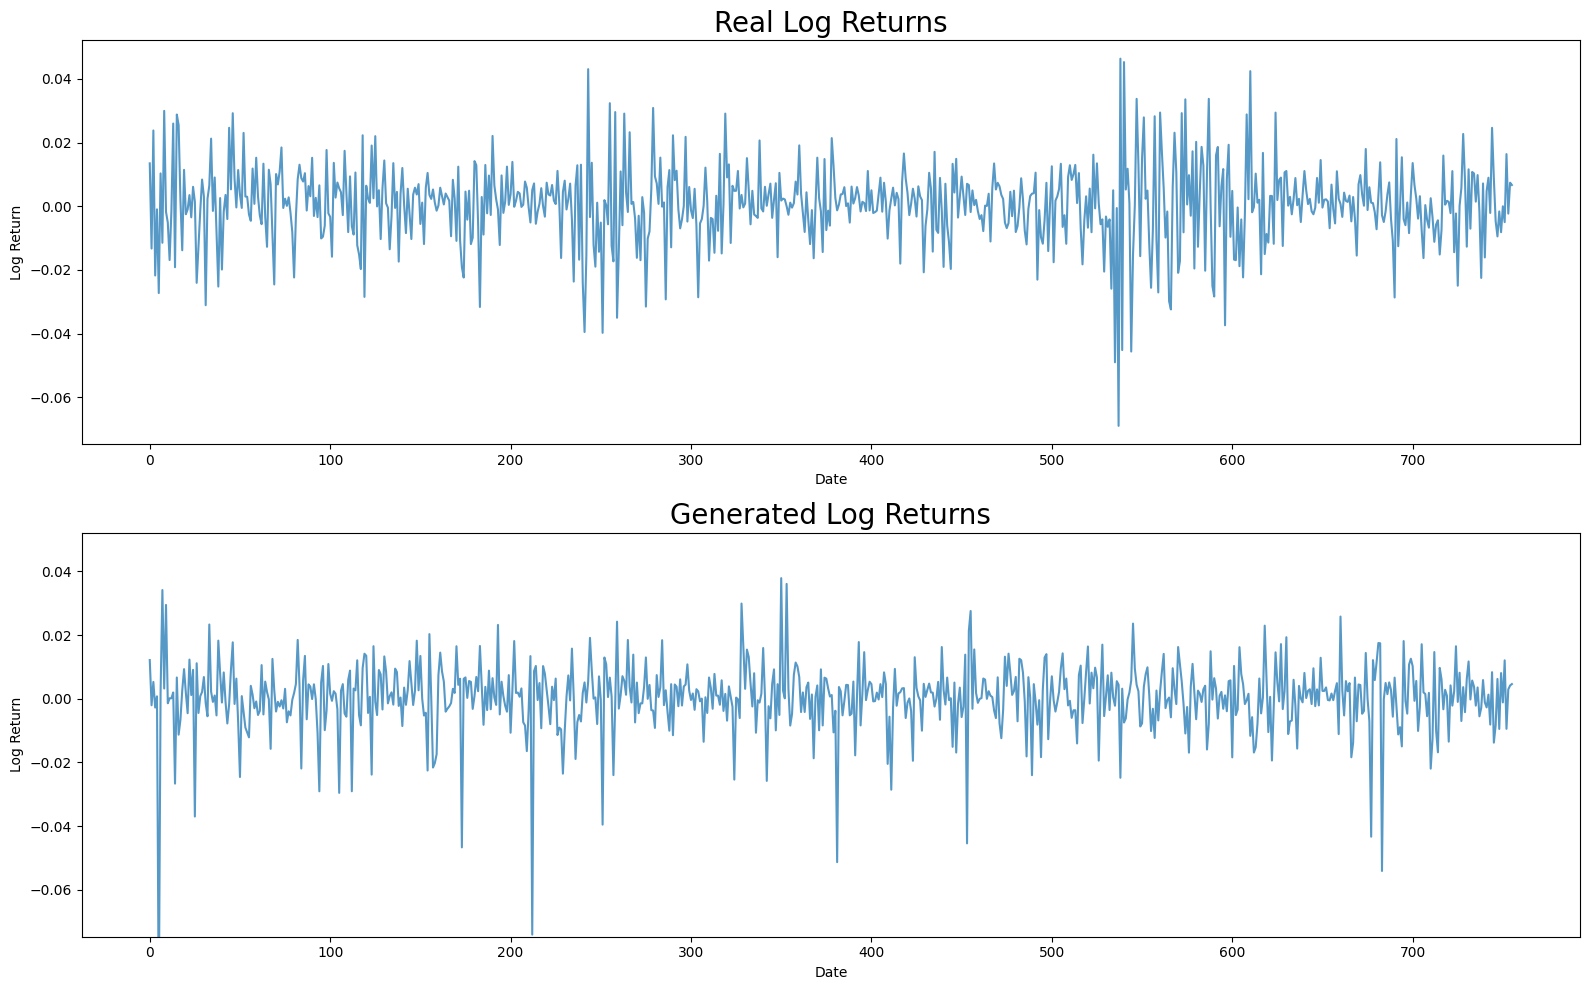

In [8]:
# plot the real and generated log returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# 첫 번째 subplot: Real Log Returns
ax1.plot(log_returns[:756], alpha=0.75)
ax1.set_title('Real Log Returns', fontsize=20)
ax1.set_xlabel('Date')
ax1.set_ylabel('Log Return')

# 두 번째 subplot: Generated Log Returns
ax2.plot(y[0].T, alpha=0.75)
ax2.set_title('Generated Log Returns', fontsize=20)
ax2.set_xlabel('Date')
ax2.set_ylabel('Log Return')

ax1_ylim = ax1.get_ylim()
ax2.set_ylim(ax1_ylim)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'log return path')

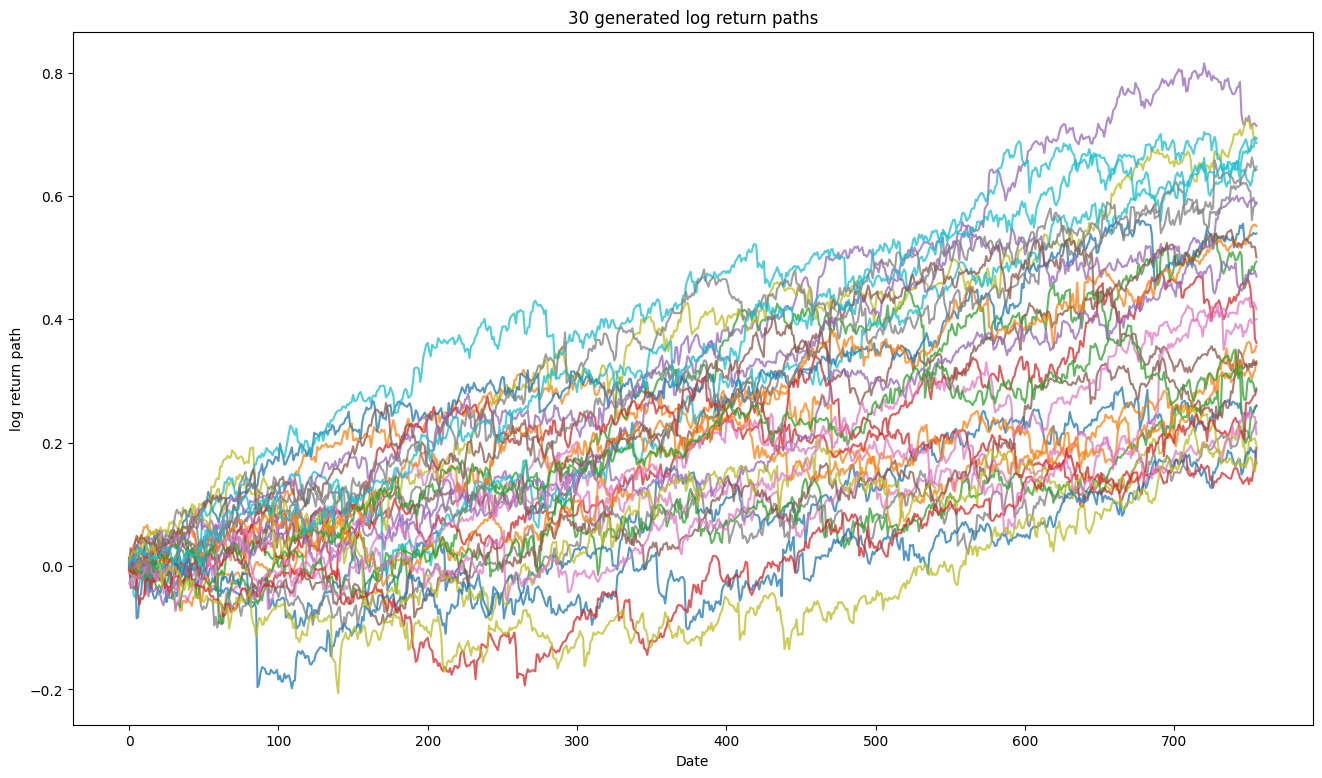

In [9]:
# plot the 30 generated log return paths
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('Date')
ax.set_ylabel('log return path')

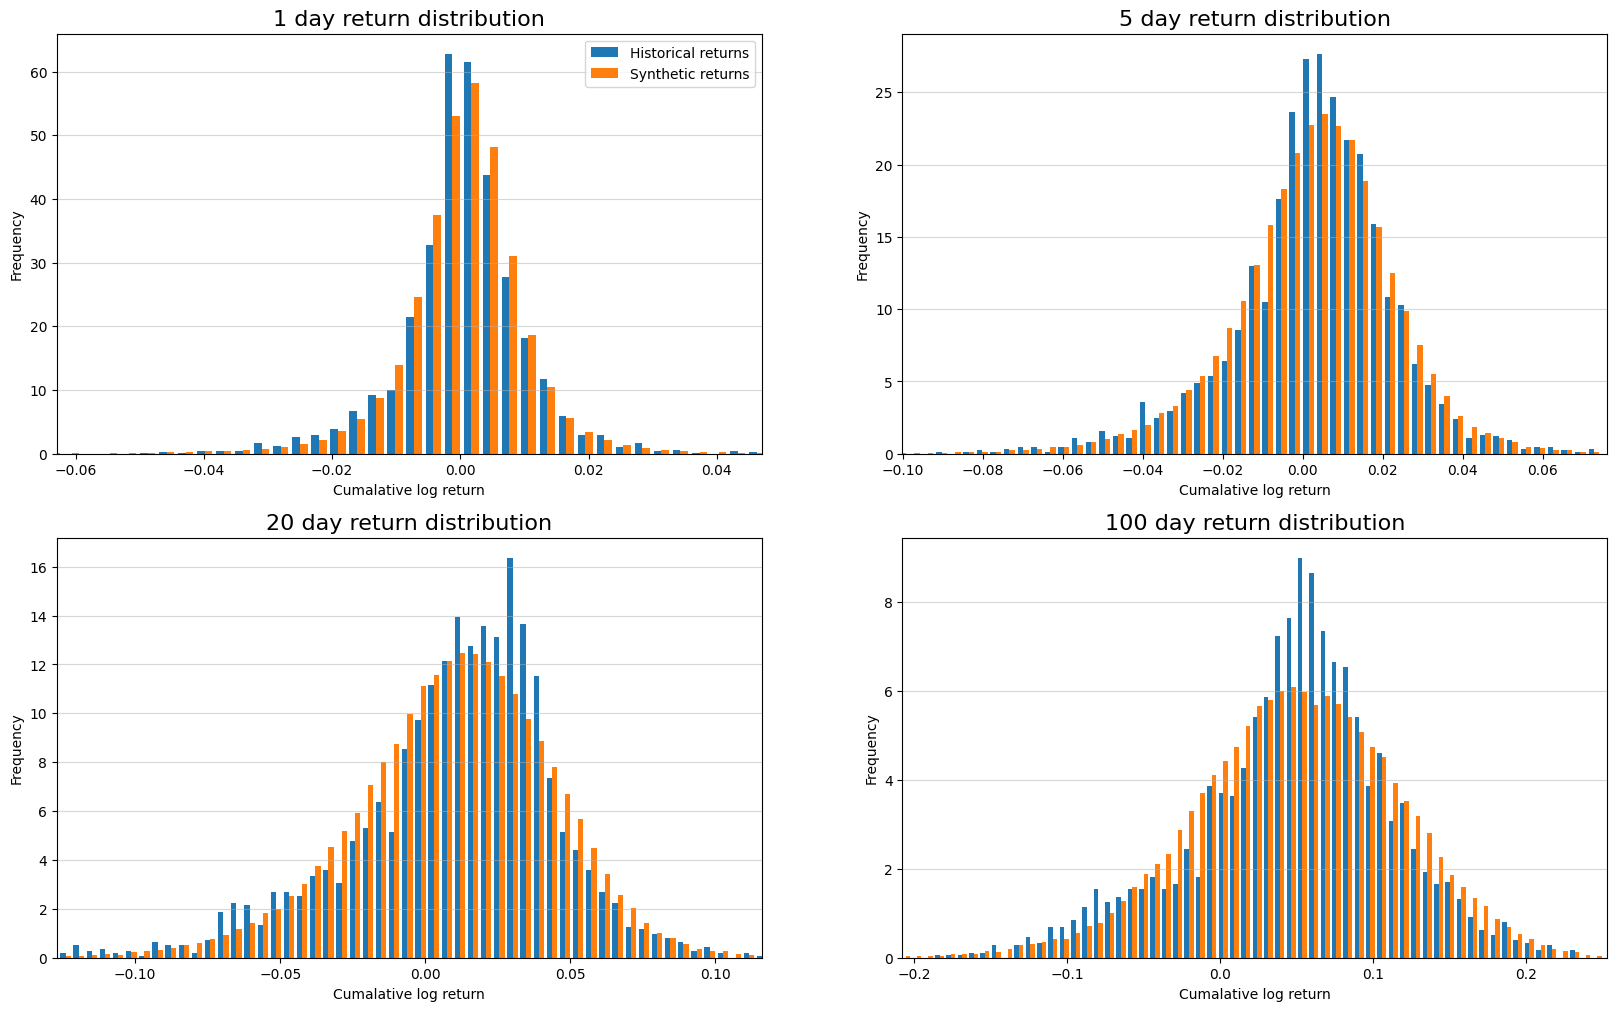

In [10]:
# plot the distribution of the real and generated log returns
n_bins = 50
windows = [1, 5, 20, 100]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

for i in range(len(windows)):
    row = min(max(0, i-1), 1) 
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=80, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])

In [11]:
# Stylized Facts test
KT_1 = []
KT_5 = []
KT_20 = []
KT_100 = []
HC = []
VC = []
VC_idx = []

returns_real = log_returns.reshape(-1)
returns_df_real = pd.DataFrame({'Daily': returns_real})
returns_df_real['Cumulative_5'] = returns_df_real['Daily'].rolling(window=5).sum()
returns_df_real['Cumulative_20'] = returns_df_real['Daily'].rolling(window=20).sum()
returns_df_real['Cumulative_100'] = returns_df_real['Daily'].rolling(window=100).sum()
    
kurtosis_1day = kurtosis(returns_df_real['Daily'].dropna())
kurtosis_5day = kurtosis(returns_df_real['Cumulative_5'].dropna())
kurtosis_20day = kurtosis(returns_df_real['Cumulative_20'].dropna())
kurtosis_100day = kurtosis(returns_df_real['Cumulative_100'].dropna())

print(f"Real Kurtosis (1-day) real : {kurtosis_1day}")    
print(f"Real Kurtosis (5-day) real : {kurtosis_5day}")    
print(f"Real Kurtosis (20-day) real : {kurtosis_20day}")    
print(f"Real Kurtosis (100-day) real : {kurtosis_100day}")  
print()  

for j in range(len(y)):
    
    # Kurtosis
    returns_df = pd.DataFrame({'Daily': y[j]})
    returns_df['Cumulative_5'] = returns_df['Daily'].rolling(window=5).sum()
    returns_df['Cumulative_20'] = returns_df['Daily'].rolling(window=20).sum()
    returns_df['Cumulative_100'] = returns_df['Daily'].rolling(window=100).sum()
    
    kurtosis_1day = kurtosis(returns_df['Daily'].dropna())
    kurtosis_5day = kurtosis(returns_df['Cumulative_5'].dropna())
    kurtosis_20day = kurtosis(returns_df['Cumulative_20'].dropna())
    kurtosis_100day = kurtosis(returns_df['Cumulative_100'].dropna())
    
    KT_1.append(kurtosis_1day)
    KT_5.append(kurtosis_5day)
    KT_20.append(kurtosis_20day)
    KT_100.append(kurtosis_100day)
    
    # Hurst Exponent
    H, c, data_range = compute_Hc(y[j].cumsum())
    HC.append(H)
    
    # volatility clustering
    model = arch_model(y[j], vol='Garch', p=1, q=1, rescale=False)
    results = model.fit(disp='off')
    arch_lm_test = results.arch_lm_test()
    VC.append(arch_lm_test.pval < 0.05)
    if arch_lm_test.pval < 0.05:
        VC_idx.append(j)

# Kurtosis
print(f"Synthetic Kurtosis (1-day) fake : {sum(KT_1)/len(y)}")
print(f"Synthetic Kurtosis (5-day) fake : {sum(KT_5)/len(y)}")
print(f"Synthetic Kurtosis (20-day) fake : {sum(KT_20)/len(y)}")
print(f"Synthetic Kurtosis (100-day) fake : {sum(KT_100)/len(y)}")
print()

# Hurst exponent    
H, c, data_range = compute_Hc(returns_real.cumsum())
print(f'Real Hurst Exponent {H}')
print(f'Synthetic Hurst Exponent {sum(HC)/len(y)}')
print()

# Volatility clustering
model = arch_model(returns_real, vol='Garch', p=1, q=1, rescale=False)
results = model.fit(disp='off')
arch_lm_test = results.arch_lm_test()
print(f"Engle's ARCH LM Test: p-value = {arch_lm_test.pval}")
print(f"Volatility Clustering: {sum(VC)} / {len(y)} = {sum(VC)/len(y)}")


Real Kurtosis (1-day) real : 4.198586327543516
Real Kurtosis (5-day) real : 3.441086861730189
Real Kurtosis (20-day) real : 2.0360098078446303
Real Kurtosis (100-day) real : 0.5043199021345144



/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Synthetic Kurtosis (1-day) fake : 9.992896586227332
Synthetic Kurtosis (5-day) fake : 2.1632023124781687
Synthetic Kurtosis (20-day) fake : 0.4917004123042695
Synthetic Kurtosis (100-day) fake : -0.25641443910659434

Real Hurst Exponent 0.6103283814508548
Synthetic Hurst Exponent 0.5665374466152748

Engle's ARCH LM Test: p-value = 0.0
Volatility Clustering: 9 / 91 = 0.0989010989010989


/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


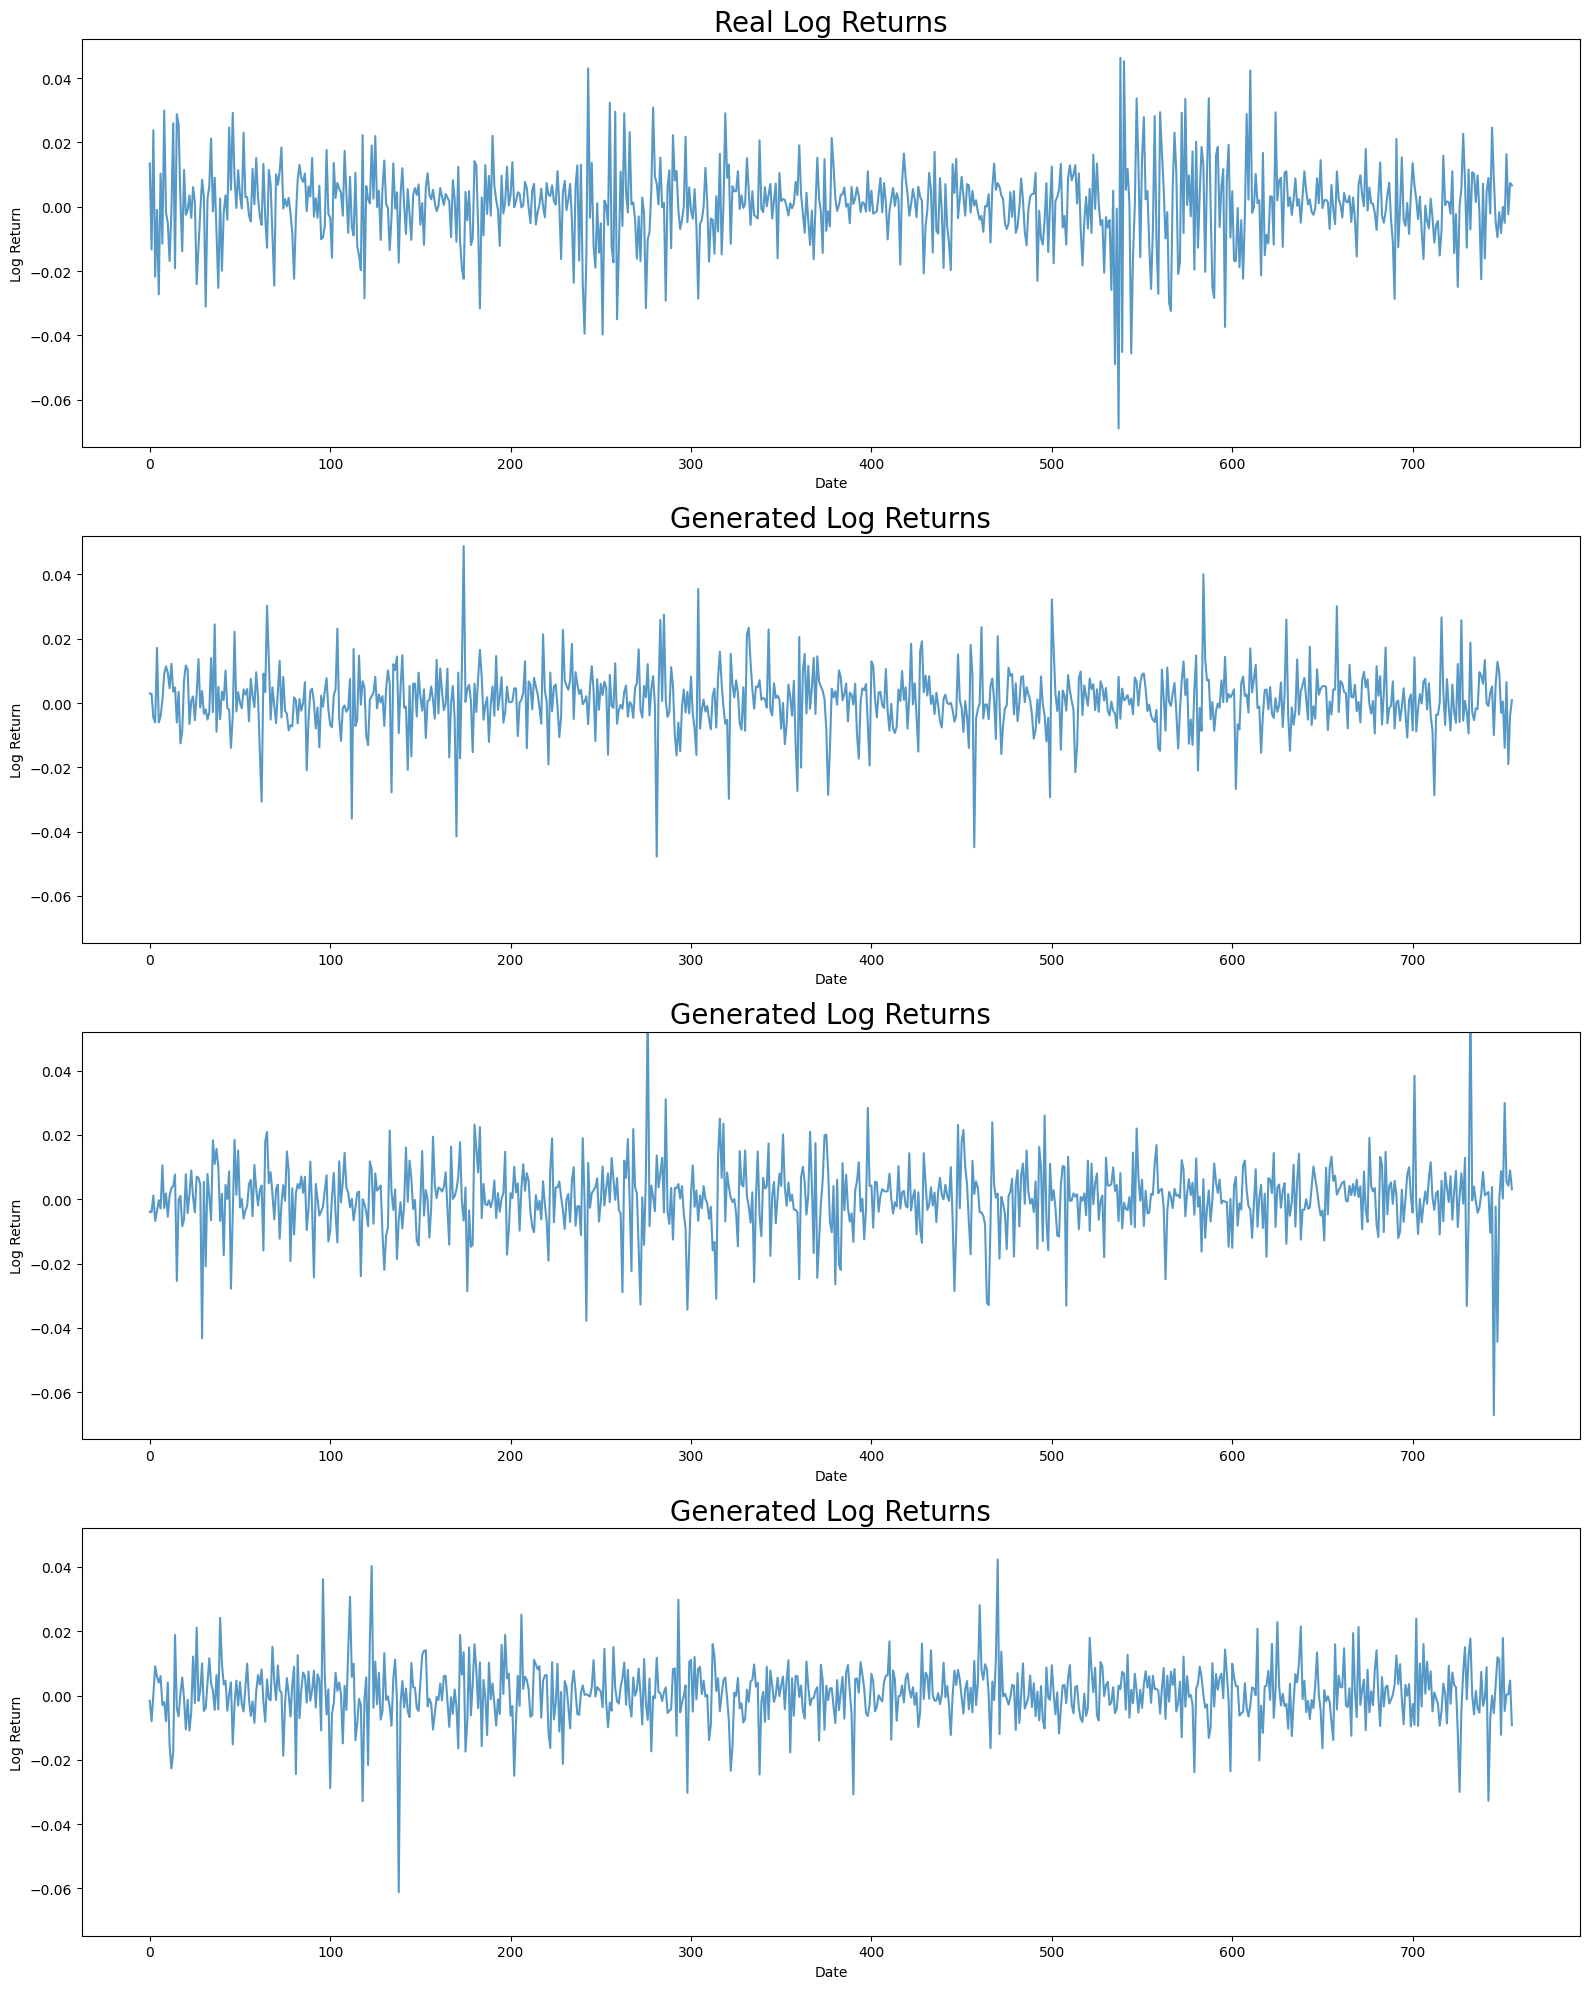

In [12]:
# log returns of synthetic data that passed volatility clustering test
VC_iter = iter(VC_idx)
fig, (axss) = plt.subplots(4, 1, figsize=(16, 20))

axss[0].plot(log_returns[:756], alpha=0.75)
axss[0].set_title('Real Log Returns', fontsize=20)
axss[0].set_xlabel('Date')
axss[0].set_ylabel('Log Return')
axss[0].set_ylim(ax1_ylim)

for num in range(1, 4):
    idx = next(VC_iter)
    axss[num].plot(y[idx].T, alpha=0.75)
    axss[num].set_title('Generated Log Returns', fontsize=20)
    axss[num].set_xlabel('Date')
    axss[num].set_ylabel('Log Return')    
    axss[num].set_ylim(ax1_ylim)
    
plt.tight_layout()
plt.show()

In [13]:
# Correlation Analysis of synthetic data
df_all = []        
for i in range(n_groups):
    standardScaler1 = joblib.load(f'./Dataset/pickle/{i}_standardScaler1.pkl')
    standardScaler2 = joblib.load(f'./Dataset/pickle/{i}_standardScaler2.pkl')
    gaussianize = joblib.load(f'./Dataset/pickle/{i}_gaussianize.pkl')    
    log_returns_corr = joblib.load(f'./Dataset/pickle/{i}_log_returns.pkl')        
    
    y = generator[i](noise).cpu().detach().squeeze()
    y = (y - y.mean(axis=0))/y.std(axis=0)
    y = standardScaler2.inverse_transform(y)
    y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
    y = standardScaler1.inverse_transform(y)
    
    df = pd.DataFrame(y)
    df = df[(y.max(axis=1) <= 2.0 * log_returns_corr.max()) & (y.min(axis=1) >= 2.0 * log_returns_corr.min())]
    df_all.append(df)
    
df_merge = pd.concat(df_all, axis=1)
df_merge.dropna(axis=0, inplace=True)

corr_list1 = []
corr_list2 = []
corr_list3 = []
for index, row in df_merge.iterrows():
    df1 = row[0:asset_length]
    df2 = row[asset_length:asset_length*2]
    df3 = row[asset_length*2:asset_length*3]
    df_final = pd.DataFrame({'Asset1':df1, 'Asset2':df2, 'Asset3':df3})
    corr_matrix = df_final.corr()
    corr1_corr2 = corr_matrix.loc['Asset1', 'Asset2']
    corr1_corr3 = corr_matrix.loc['Asset1', 'Asset3']
    corr2_corr3 = corr_matrix.loc['Asset2', 'Asset3']
    corr_list1.append(corr1_corr2)
    corr_list2.append(corr1_corr3)
    corr_list3.append(corr2_corr3)

df_1 = pd.DataFrame(corr_list1, columns=['corr1-corr2'])
df_2 = pd.DataFrame(corr_list2, columns=['corr1-corr3'])
df_3 = pd.DataFrame(corr_list3, columns=['corr2-corr3'])

corr_df = pd.concat([df_1, df_2, df_3], axis=1)
avg_corr = corr_df.mean()
var_corr = corr_df.std()

print('Mean of synthetic data correlation')
print(avg_corr)
print()
print('Standard Deviation of synthetic data correlation')
print(var_corr)

Mean of synthetic data correlation
corr1-corr2   -0.340226
corr1-corr3   -0.507411
corr2-corr3    0.513605
dtype: float64

Standard Deviation of synthetic data correlation
corr1-corr2    0.033360
corr1-corr3    0.031882
corr2-corr3    0.032012
dtype: float64


In [14]:
# correlation Analysis of real data
with open('./Dataset/stocks.csv', 'rb') as fh:
    df = pd.read_csv(fh)
date = pd.to_datetime(df.iloc[1:, 0], format='%Y-%m-%d')
df = df.iloc[:, 1:].apply(pd.to_numeric).astype(float)
df_log_return = np.log(df / df.shift(1))[1:]

print('correlation matrix of real data')
df_log_return.corr()

correlation matrix of real data


,SP500,HANGSENG,KOSPI
SP500,1.000000,0.232540,0.221872
HANGSENG,0.232540,1.000000,0.651573
KOSPI,0.221872,0.651573,1.000000


In [17]:
### save the synthetic multi-vartie time series data 

# Make the directory for saving the results
if not os.path.isdir(f'./Outputs/'):
    os.mkdir(f'./Outputs/')   
if not os.path.isdir(f'./Outputs/{full_name}/'):
    os.mkdir(f'./Outputs/{full_name}/')    
output_dir = f'./Outputs/{full_name}'
        
for i in range(n_groups):
    standardScaler1 = joblib.load(f'./Dataset/pickle/{i}_standardScaler1.pkl')
    standardScaler2 = joblib.load(f'./Dataset/pickle/{i}_standardScaler2.pkl')
    gaussianize = joblib.load(f'./Dataset/pickle/{i}_gaussianize.pkl')    
    log_returns_corr = joblib.load(f'./Dataset/pickle/{i}_log_returns.pkl')        
    
    y = generator[i](noise).cpu().detach().squeeze()
    y = (y - y.mean(axis=0))/y.std(axis=0)
    y = standardScaler2.inverse_transform(y)
    y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
    y = standardScaler1.inverse_transform(y)    
    df = pd.DataFrame(y)
    print(df.shape)
    
    file_name = f'stock_{i}.csv'
    df.to_csv(os.path.join(output_dir, file_name))

(100, 756)
(100, 756)
(100, 756)
